<a href="https://colab.research.google.com/github/Vaishnavi-TCD/TCD/blob/main/OADA_Final_Assgn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

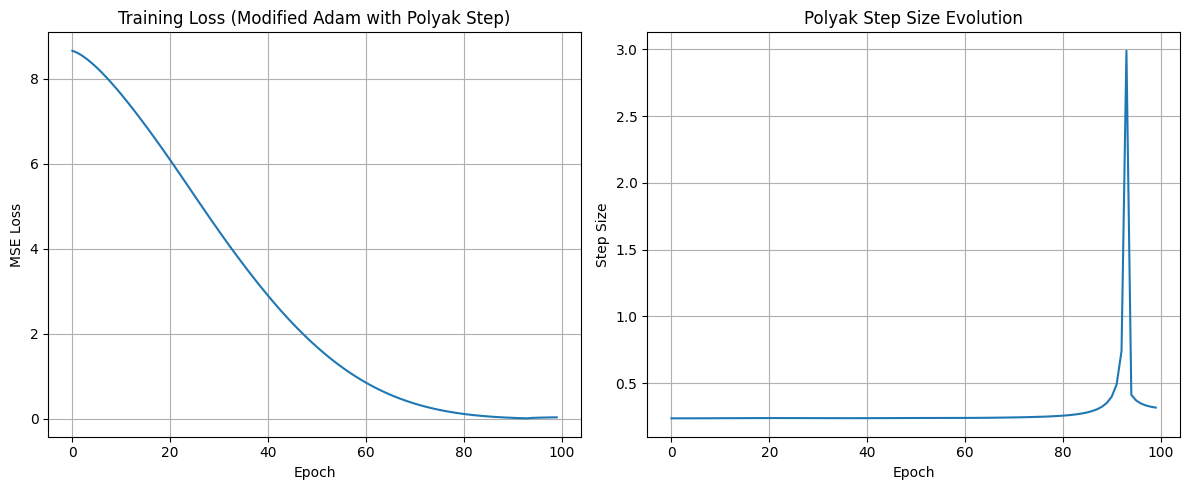

Learned weight: 3.1466, Learned bias: 1.0129


In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Step 1: Generate synthetic noisy data
torch.manual_seed(0)
n_samples = 100
X = torch.randn(n_samples, 1)
true_w = 3.0
true_b = 1.0
noise = 0.1 * torch.randn(n_samples, 1)
y = true_w * X + true_b + noise

# Step 2: Define a simple linear regression model
class SimpleLinearModel(nn.Module):
    def __init__(self):
        super(SimpleLinearModel, self).__init__()
        self.linear = nn.Linear(1, 1)

    def forward(self, x):
        return self.linear(x)

# Step 3: Define training with modified Adam (Polyak step size)
def train_modified_adam_polyak(model, X, y, num_epochs=100, epsilon=1e-8):
    loss_fn = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=1.0)  # lr is dummy, we'll override manually
    train_losses = []
    step_sizes = []

    for epoch in range(num_epochs):
        model.train()
        optimizer.zero_grad()
        predictions = model(X)
        loss = loss_fn(predictions, y)
        loss.backward()

        # Calculate Polyak step size
        grad_norm_squared = sum((param.grad**2).sum() for param in model.parameters() if param.grad is not None)
        grad_norm_squared = grad_norm_squared.item()
        polyak_step = (loss.item()) / (grad_norm_squared + epsilon)

        # Manual parameter update using Adam momentum but Polyak step
        with torch.no_grad():
            for group in optimizer.param_groups:
                for p in group['params']:
                    if p.grad is None:
                        continue
                    state = optimizer.state[p]

                    # Initialize state if first time
                    if len(state) == 0:
                        state['exp_avg'] = torch.zeros_like(p)
                        state['exp_avg_sq'] = torch.zeros_like(p)
                        state['step'] = 0

                    exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                    beta1, beta2 = 0.9, 0.999

                    state['step'] += 1

                    exp_avg.mul_(beta1).add_(p.grad, alpha=1 - beta1)
                    exp_avg_sq.mul_(beta2).addcmul_(p.grad, p.grad, value=1 - beta2)

                    bias_correction1 = 1 - beta1 ** state['step']
                    bias_correction2 = 1 - beta2 ** state['step']

                    adapted_lr = polyak_step * (bias_correction2**0.5) / bias_correction1

                    denom = (exp_avg_sq.sqrt() / (bias_correction2**0.5)).add_(epsilon)
                    step = adapted_lr * (exp_avg / denom)

                    p.add_(-step)

        train_losses.append(loss.item())
        step_sizes.append(polyak_step)

    return train_losses, step_sizes

# Step 4: Train model
model = SimpleLinearModel()
train_losses, step_sizes = train_modified_adam_polyak(model, X, y, num_epochs=100)

# Step 5: Plot Loss and Step Size
plt.figure(figsize=(12,5))

# Loss curve
plt.subplot(1,2,1)
plt.plot(train_losses)
plt.title('Training Loss (Modified Adam with Polyak Step)')
plt.xlabel('Epoch')
plt.ylabel('MSE Loss')
plt.grid(True)

# Step size curve
plt.subplot(1,2,2)
plt.plot(step_sizes)
plt.title('Polyak Step Size Evolution')
plt.xlabel('Epoch')
plt.ylabel('Step Size')
plt.grid(True)

plt.tight_layout()
plt.show()

# Final model parameters
w_learned = model.linear.weight.item()
b_learned = model.linear.bias.item()
print(f"Learned weight: {w_learned:.4f}, Learned bias: {b_learned:.4f}")


[SGD] Iter 0: Train Loss 3.8011, Val Loss 3.8024
[SGD] Iter 100: Train Loss 2.7487, Val Loss 2.7510
[SGD] Iter 200: Train Loss 2.0158, Val Loss 2.0230
[SGD] Iter 300: Train Loss 1.9647, Val Loss 1.9748
[SGD] Iter 400: Train Loss 1.8745, Val Loss 1.8851
[SGD] Iter 500: Train Loss 1.7975, Val Loss 1.8114
[SGD] Iter 600: Train Loss 1.7568, Val Loss 1.7705
[SGD] Iter 700: Train Loss 1.6472, Val Loss 1.6613
[SGD] Iter 800: Train Loss 1.5211, Val Loss 1.5347
[SGD] Iter 900: Train Loss 1.3501, Val Loss 1.3722
[Polyak] Iter 0: Train Loss 4.3958, Val Loss 4.3981
[Polyak] Iter 100: Train Loss 4.2510, Val Loss 4.2612
[Polyak] Iter 200: Train Loss 4.2659, Val Loss 4.2908
[Polyak] Iter 300: Train Loss 4.0255, Val Loss 4.0533
[Polyak] Iter 400: Train Loss 3.3925, Val Loss 3.3867
[Polyak] Iter 500: Train Loss 6.8131, Val Loss 6.7976
[Polyak] Iter 600: Train Loss 2.9239, Val Loss 2.9259
[Polyak] Iter 700: Train Loss 3.4453, Val Loss 3.4428
[Polyak] Iter 800: Train Loss 3.9857, Val Loss 3.9822
[Polyak]

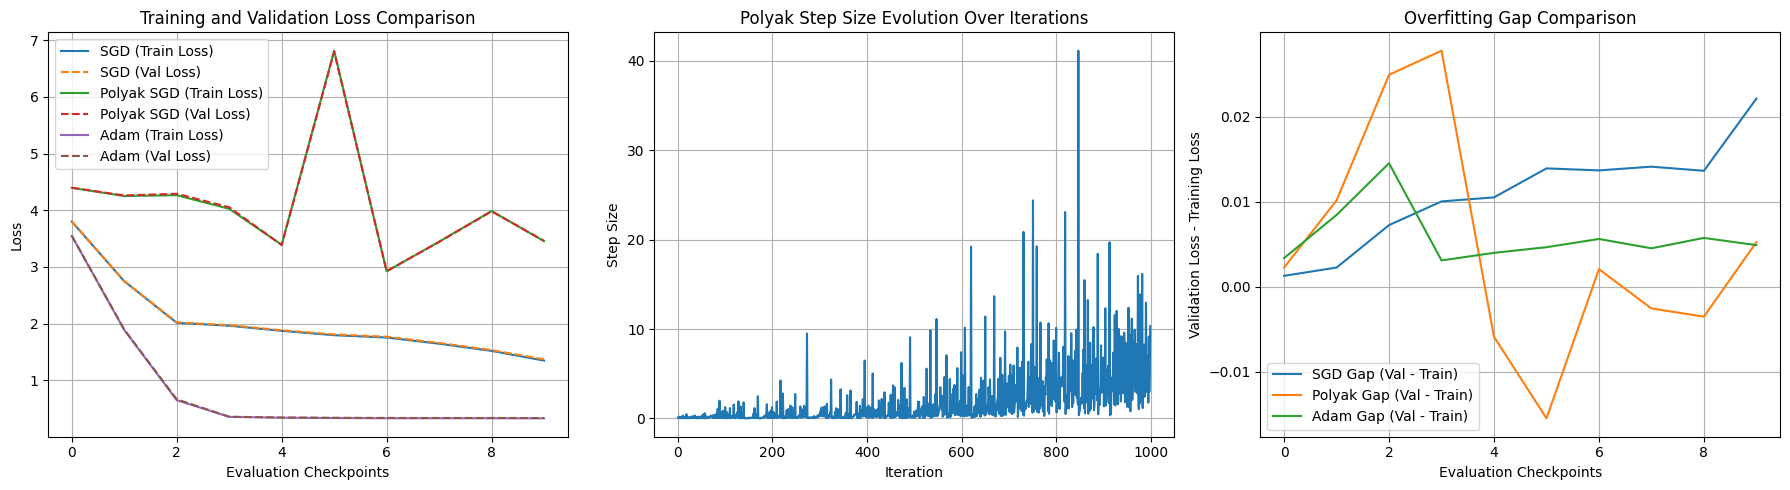

In [2]:
import torch
import torch.nn as nn
from torch.nn import functional as F
import matplotlib.pyplot as plt

# ========== Your Week 9 GPT Model ==========

batch_size = 64
block_size = 256
max_iters = 1000  # reduced iterations
eval_interval = 100
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 100
n_embd = 384
n_head = 6
n_layer = 6
dropout = 0.2

torch.manual_seed(1337)

# Load data
with open('/content/input_childSpeech_trainingSet.txt', 'r', encoding='utf-8') as f:
    text = f.read()

chars = sorted(list(set(text)))
vocab_size = len(chars)
stoi = { ch:i for i,ch in enumerate(chars) }
itos = { i:ch for i,ch in enumerate(chars) }
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l])

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    data_split = train_data if split == 'train' else val_data
    ix = torch.randint(len(data_split) - block_size, (batch_size,))
    x = torch.stack([data_split[i:i+block_size] for i in ix])
    y = torch.stack([data_split[i+1:i+block_size+1] for i in ix])
    return x.to(device), y.to(device)

@torch.no_grad()
def estimate_loss(model):
    out = {}
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embd, head_size, bias=False)
        self.query = nn.Linear(n_embd, head_size, bias=False)
        self.value = nn.Linear(n_embd, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        wei = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        wei = wei.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out

class MultiHeadAttention(nn.Module):
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embd)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out))
        return out

class FeedForward(nn.Module):
    def __init__(self, n_embd):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embd, 4 * n_embd),
            nn.ReLU(),
            nn.Linear(4 * n_embd, n_embd),
            nn.Dropout(dropout)
        )

    def forward(self, x):
        return self.net(x)

class Block(nn.Module):
    def __init__(self, n_embd, n_head):
        super().__init__()
        head_size = n_embd // n_head
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embd)
        self.ln1 = nn.LayerNorm(n_embd)
        self.ln2 = nn.LayerNorm(n_embd)

    def forward(self, x):
        x = x + self.sa(self.ln1(x))
        x = x + self.ffwd(self.ln2(x))
        return x

class GPTLanguageModel(nn.Module):
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embd)
        self.position_embedding_table = nn.Embedding(block_size, n_embd)
        self.blocks = nn.Sequential(*[Block(n_embd, n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embd)
        self.lm_head = nn.Linear(n_embd, vocab_size)
        self.apply(self._init_weights)

    def _init_weights(self, module):
        if isinstance(module, nn.Linear) or isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if isinstance(module, nn.Linear) and module.bias is not None:
                torch.nn.init.zeros_(module.bias)

    def forward(self, idx, targets=None):
        B, T = idx.shape
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device))
        x = tok_emb + pos_emb
        x = self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x)
        if targets is None:
            loss = None
        else:
            logits = logits.view(-1, logits.size(-1))
            targets = targets.view(-1)
            loss = F.cross_entropy(logits, targets)
        return logits, loss

def train_constant_sgd(model, learning_rate=0.1):  # Increased learning rate for better convergence
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    return train_model(model, optimizer)

def train_adam(model, learning_rate=2e-4):  # Tuned Adam learning rate for more stability
    optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
    return train_model(model, optimizer)

def train_polyak(model, epsilon=1e-8):
    model.train()
    train_losses = []
    val_losses = []
    polyak_step_sizes = []
    for iter in range(max_iters):
        xb, yb = get_batch('train')
        model.zero_grad()
        logits, loss = model(xb, yb)
        loss.backward()
        grad_norm_squared = sum((param.grad**2).sum() for param in model.parameters() if param.grad is not None)
        grad_norm_squared = grad_norm_squared.item()
        polyak_step = loss.item() / (grad_norm_squared + epsilon)
        polyak_step_sizes.append(polyak_step)

        with torch.no_grad():
            for param in model.parameters():
                if param.grad is not None:
                    param -= polyak_step * param.grad

        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"[Polyak] Iter {iter}: Train Loss {losses['train']:.4f}, Val Loss {losses['val']:.4f}")

    return train_losses, val_losses, polyak_step_sizes

def train_model(model, optimizer):
    model.train()
    train_losses = []
    val_losses = []
    for iter in range(max_iters):
        xb, yb = get_batch('train')
        logits, loss = model(xb, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if iter % eval_interval == 0:
            losses = estimate_loss(model)
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])
            print(f"[{type(optimizer).__name__}] Iter {iter}: Train Loss {losses['train']:.4f}, Val Loss {losses['val']:.4f}")

    return train_losses, val_losses, None

# ========== Run Training for Each Method ==========

# SGD with constant step size (tuned)
model_sgd = GPTLanguageModel().to(device)
sgd_train_losses, sgd_val_losses, _ = train_constant_sgd(model_sgd)

# Polyak Step Size
model_polyak = GPTLanguageModel().to(device)
polyak_train_losses, polyak_val_losses, polyak_step_sizes = train_polyak(model_polyak)

# Adam Optimizer (tuned)
model_adam = GPTLanguageModel().to(device)
adam_train_losses, adam_val_losses, _ = train_adam(model_adam)

# ========== Calculate Overfitting Gap ==========

sgd_gap = [val - train for train, val in zip(sgd_train_losses, sgd_val_losses)]
polyak_gap = [val - train for train, val in zip(polyak_train_losses, polyak_val_losses)]
adam_gap = [val - train for train, val in zip(adam_train_losses, adam_val_losses)]

# ========== Plot Comparison ==========

plt.figure(figsize=(18,5))

# Plot 1: Loss Comparison
plt.subplot(1,3,1)
plt.plot(sgd_train_losses, label='SGD (Train Loss)')
plt.plot(sgd_val_losses, '--', label='SGD (Val Loss)')
plt.plot(polyak_train_losses, label='Polyak SGD (Train Loss)')
plt.plot(polyak_val_losses, '--', label='Polyak SGD (Val Loss)')
plt.plot(adam_train_losses, label='Adam (Train Loss)')
plt.plot(adam_val_losses, '--', label='Adam (Val Loss)')
plt.title('Training and Validation Loss Comparison')
plt.xlabel('Evaluation Checkpoints')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Plot 2: Polyak Step Size Evolution
plt.subplot(1,3,2)
plt.plot(polyak_step_sizes)
plt.title('Polyak Step Size Evolution Over Iterations')
plt.xlabel('Iteration')
plt.ylabel('Step Size')
plt.grid(True)

# Plot 3: Overfitting Gap Comparison
plt.subplot(1,3,3)
plt.plot(sgd_gap, label='SGD Gap (Val - Train)')
plt.plot(polyak_gap, label='Polyak Gap (Val - Train)')
plt.plot(adam_gap, label='Adam Gap (Val - Train)')
plt.title('Overfitting Gap Comparison')
plt.xlabel('Evaluation Checkpoints')
plt.ylabel('Validation Loss - Training Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
